In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tensorflow.keras.applications import VGG16

2025-09-15 01:49:21.493140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757900961.666300      75 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757900961.715671      75 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (224, 224)
BATCH = 32
AUTOTUNE = tf.data.AUTOTUNE

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/esai-arsen-v3/dataset-v3/train",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=None,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/esai-arsen-v3/dataset-v3/val",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=None,
    seed=123
)

# Get class names
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# Data preprocessing and augmentation
def preprocess_data(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0  # Normalize to [0, 1]
    return image, label

# Data augmentation for training
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),                 # flip kanan-kiri
    layers.RandomRotation(0.15),                     # rotasi ±15%
    layers.RandomZoom(0.15),                         # zoom in/out
    layers.RandomTranslation(0.1, 0.1),              # geser ±10%
    layers.RandomContrast(0.15),                     # kontras
    layers.GaussianNoise(0.02),                      # noise ringan
], name="data_aug")

def augment_data(image, label):
    image = data_augmentation(image)
    return image, label

# Apply preprocessing
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)

# Apply augmentation only to training data
train_ds = train_ds.map(augment_data, num_parallel_calls=AUTOTUNE)

# Optimize pipeline performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9341 files belonging to 4 classes.


I0000 00:00:1757900983.457317      75 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2337 files belonging to 4 classes.
Classes: ['a_Baik', 'b_Sedang', 'c_Tidak_Sehat', 'd_Sangat_Tidak_Sehat']


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Langkah 2: Freeze layers awal (misalnya, freeze semua kecuali 4 block terakhir)
for layer in base_model.layers[:-4]:  # Freeze layers sebelum block conv terakhir
    layer.trainable = False

In [5]:
# Langkah 3: Tambah custom top layers untuk klasifikasi
x = base_model.output
x = layers.Flatten()(x)  
x = layers.Dense(512, activation='relu')(x)  
x = layers.Dropout(0.5)(x)  
x = layers.Dense(4, activation='softmax')(x)  

In [6]:
# Buat model final
model = Model(inputs=base_model.input, outputs=x)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,562,308 (105.14 MB)

 Trainable params: 19,927,044 (76.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    ]
)

Epoch 1/100


I0000 00:00:1757900992.649197     128 service.cc:148] XLA service 0x7d1690002fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757900992.650079     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757900993.421034     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/292 ━━━━━━━━━━━━━━━━━━━━ 28s 98ms/step - accuracy: 0.2656 - loss: 1.7924   

I0000 00:00:1757901002.727365     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


292/292 ━━━━━━━━━━━━━━━━━━━━ 92s 270ms/step - accuracy: 0.5765 - loss: 0.9846 - val_accuracy: 0.8545 - val_loss: 0.3506 - learning_rate: 1.0000e-04
Epoch 2/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.8763 - loss: 0.3042 - val_accuracy: 0.8832 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 3/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.9326 - loss: 0.1719 - val_accuracy: 0.9251 - val_loss: 0.1898 - learning_rate: 1.0000e-04
Epoch 4/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 31s 108ms/step - accuracy: 0.9573 - loss: 0.1128 - val_accuracy: 0.9136 - val_loss: 0.2377 - learning_rate: 1.0000e-04
Epoch 5/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/step - accuracy: 0.9654 - loss: 0.0870 - val_accuracy: 0.9452 - val_loss: 0.1575 - learning_rate: 1.0000e-04
Epoch 6/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 31s 107ms/step - accuracy: 0.9744 - loss: 0.0715 - val_accuracy: 0.9208 - val_loss: 0.2371 - learning_rate: 1.0000e-04
Epoch 7/100
292/292 ━━━━━━━━━━━━━━━━━━━━ 32s 108ms/s

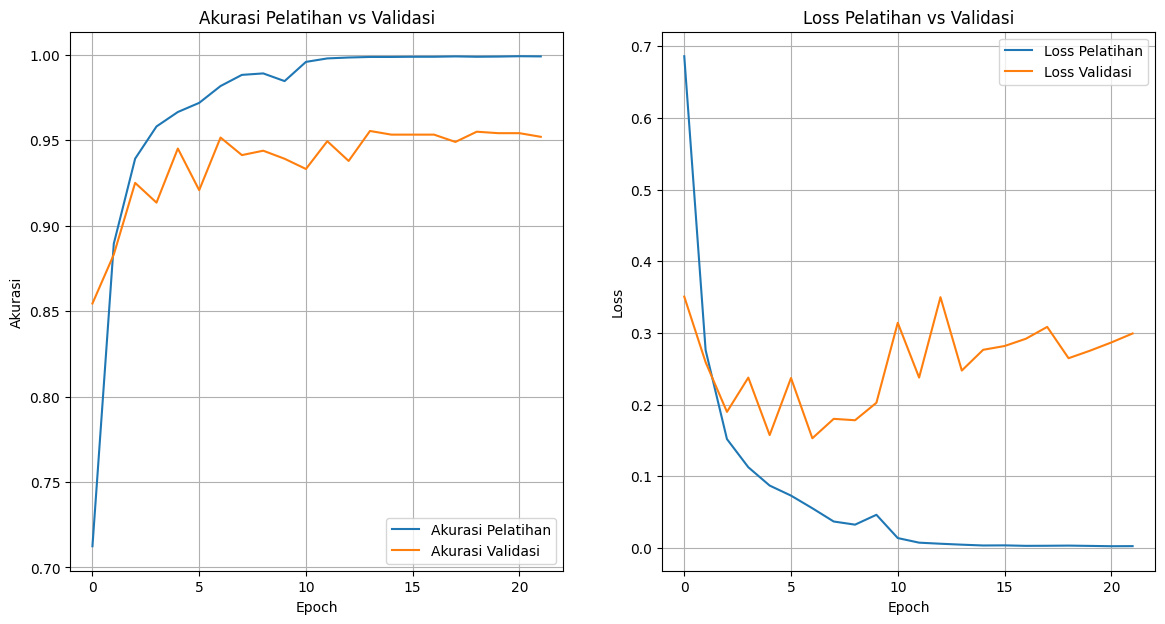

In [14]:
import matplotlib.pyplot as plt

# Mendapatkan nilai loss dan akurasi dari objek history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Membuat plot untuk Akurasi
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Akurasi Pelatihan')
plt.plot(epochs_range, val_acc, label='Akurasi Validasi')
plt.legend(loc='lower right')
plt.title('Akurasi Pelatihan vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.grid(True)

# Membuat plot untuk Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Loss Pelatihan')
plt.plot(epochs_range, val_loss, label='Loss Validasi')
plt.legend(loc='upper right')
plt.title('Loss Pelatihan vs Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.savefig('plot_VGG16.png') 
plt.show()

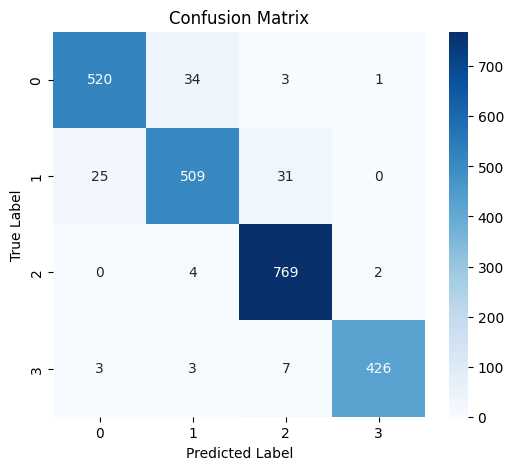

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       558
           1       0.93      0.90      0.91       565
           2       0.95      0.99      0.97       775
           3       0.99      0.97      0.98       439

    accuracy                           0.95      2337
   macro avg       0.95      0.95      0.95      2337
weighted avg       0.95      0.95      0.95      2337



In [11]:
val_ds_noshuffle = val_ds.unbatch().batch(1)

y_true = []
y_pred = []

# Iterasi melalui dataset validasi untuk mendapatkan label dan prediksi
for images, labels in val_ds_noshuffle:
    # Lakukan prediksi dengan model
    preds = model.predict(images, verbose=0)
    
    # Ambil indeks dengan probabilitas tertinggi sebagai label prediksi
    y_pred.append(np.argmax(preds, axis=1)[0])
    
    # Periksa format label (one-hot atau integer) dan ambil label sebenarnya
    if labels.shape[-1] == model.output_shape[-1]:
        # Jika label one-hot, ubah ke integer
        y_true.append(np.argmax(labels.numpy(), axis=1)[0])
    else:
        # Jika label sudah dalam format integer
        y_true.append(labels.numpy()[0])

# Konversi list ke array numpy
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Bagian 2: Visualisasi Confusion Matrix ---
# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Jika Anda memiliki nama kelas, ganti list(range(cm.shape[0])) dengan nama kelas yang sesuai.
# Contoh: classes = ['cat', 'dog', 'bird']
classes = [str(c) for c in range(cm.shape[0])]

# Buat plot heatmap untuk confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Tambahkan baris ini untuk menyimpan gambar
plt.savefig("confusion_matrix_MobileNetV2.png")
plt.show()

# --- Bagian 3: Classification Report ---
print("Classification Report:\n")
# Cetak laporan klasifikasi yang berisi metrik kinerja
print(classification_report(y_true, y_pred, target_names=classes))

In [12]:
# history adalah objek yang Anda dapatkan dari model.fit()
history_df = pd.DataFrame(history.history)

# Menambahkan kolom 'epoch' untuk mempermudah analisis
history_df['epoch'] = history.epoch
print(history_df.head())

# Menyimpan DataFrame ke file CSV
# index=False agar kolom indeks tidak ikut tersimpan
history_df.to_csv('history_v6.csv', index=False)

   accuracy      loss  val_accuracy  val_loss  learning_rate  epoch
0  0.712451  0.686012      0.854514  0.350637         0.0001      0
1  0.889519  0.275981      0.883184  0.259158         0.0001      1
2  0.939300  0.151920      0.925118  0.189849         0.0001      2
3  0.958142  0.112645      0.913564  0.237681         0.0001      3
4  0.966599  0.087077      0.945229  0.157480         0.0001      4


In [13]:
# Simpan seluruh model dalam format file .keras
model.save('model_MobileNetV2.keras')
model.save('model_MobileNetV2.h5')